## 特征工程

### 如何合并这些表

1. 类似 sql的iner join的方式.
用store id  把 train, store_info , 和store的洲先合起来;

用weather.merge

```
Merge DataFrame objects by performing a database-style join operation by
columns or indexes.
```

``` 
按store id  join，保留left, 
store_train_join_info = train.merge(store,how='left',on='Store')

按state left join， state 简称和全称
store_state_name = store_states.merge(state_names,how='left',left_on='State',right_on='State')

根据全称，join 天气数据
store_state_name.merge(weather,how='left',left_on='StateName',right_on='file')



```

store info and state and weather
```
store 1 state 2013-1-1  wether info
store 1 state 2013-1-2  wether info
store 1 state 2013-1-3  wether info
...
store 1 state 2015-1-1  wether info

store 2 state 2013-1-1  wether info
store 2 state 2013-1-2  wether info
store 2 state 2013-1-3  wether info
...
store 2 state 2015-1-1  wether info

```

最终按on = 'Store' and 'date',把 train 和 store_info_all join起来



2. googletrend提供的是哪个星期，哪个周。根据`星期和周`，把 store和week 把 trend join起来



3. weather 提供的每天 哪个周的情况， 根据`date 和 洲` join weather.

### 特征编码

[参考](https://blog.csdn.net/hshuihui/article/details/53259710)

category 怎么处理
数值型特征怎么处理.

目前比较熟悉的有pandas里的get_dummies做one-hot encoding.

sklearn里也有很多特征编码方法.

下面的例子是要把数值型或者字符型都用sklearn 来one-hot encoding

In [101]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import * 
import numpy as np

dataset = pd.DataFrame({'pet': ['cat', 'dog', 'dog', 'fish'],                         
'age': [4 , 6, 3, 3],                        
'salary':[4, 5, 1, 1],
'lvl':[4, 5, pd.np.nan, 1]})

In [97]:
dataset.head()

,pet,age,salary,lvl
0,cat,4,4,4.0
1,dog,6,5,5.0
2,dog,3,1,NaN
3,fish,3,1,1.0


#### get_dummies 

get_dummies对数值型也是有效果的

In [26]:
dataset.head()

,pet,age,salary,lvl
0,cat,4,4,4.0
1,dog,6,5,5.0
2,dog,3,1,NaN
3,fish,3,1,1.0


In [30]:
d =  pd.get_dummies(dataset,columns=['age','salary','pet','lvl']);
d.head()

##nan treat as [0,0....0]


,age_3,age_4,age_6,salary_1,salary_4,salary_5,pet_cat,pet_dog,pet_fish,lvl_1.0,lvl_4.0,lvl_5.0
0,0,1,0,0,1,0,1,0,0,0,1,0
1,0,0,1,0,0,1,0,1,0,0,0,1
2,1,0,0,1,0,0,0,1,0,0,0,0
3,1,0,0,1,0,0,0,0,1,1,0,0


dummy_na 就是把na也编码

In [31]:
d =  pd.get_dummies(dataset,columns=['age','salary','pet','lvl'],dummy_na=True);
d.head()

,age_3.0,age_4.0,age_6.0,age_nan,salary_1.0,salary_4.0,salary_5.0,salary_nan,pet_cat,pet_dog,pet_fish,pet_nan,lvl_1.0,lvl_4.0,lvl_5.0,lvl_nan
0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0
2,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


#### sklearn里的用法 输入2D-arrayt, 得到的是也是2Dnarray  比pd麻烦多了
* 字符型不能处理
*  Nan不能处理

In [58]:

age= OneHotEncoder(sparse = False).fit_transform( dataset[['age']])
# pet= OneHotEncoder(sparse = False).fit_transform( dataset[['pet']])
salary= OneHotEncoder(sparse = False).fit_transform( dataset[['salary']])
# lvl = OneHotEncoder(sparse = False).fit_transform( dataset[['lvl']])
d = np.hstack( (age,salary))

(4, 6)

LabelEncoder 针对字符型label. ['a','b','c']--->[0,1,2]
先LabelEncoder ,再OneHotEncoder才能达到最终的效果

In [66]:
numi_pet = LabelEncoder().fit_transform(dataset[['pet']])
print(numi_pet)
pet =  OneHotEncoder(sparse = False).fit_transform( numi_pet.reshape(-1,1))
pet

[0 1 1 2]


/opt/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

等效于LabelBinarizer

In [68]:
pet =  LabelBinarizer().fit_transform( numi_pet.reshape(-1,1))
pet

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]])

### proc_df

proc_df takes a data frame df and splits off the response variable, and
changes the df into an entirely numeric dataframe.

把y剥离，剩下的df里的特征全部numerial 化，很方便

并没有`one-hot-coding`掉，因为接下来要做`entity embedding`

```
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)
```
df,y就是特征编码后的输出，还输出了一个mapper，就是上面地套的DataFrameMaper, 用来给test set直接用了
```
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)
```

## Rossman ex

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from IPython.display import HTML
import datetime
PATH='../data/rossmann/'

In [452]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

In [453]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [454]:
# for t in tables: display(t.head())

In [588]:
train, store, store_states, state_names, googletrend, weather, test = tables

### 合并表

In [456]:
state_names.head()

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


In [457]:
store_state_name = store_states.merge(state_names,how='left',left_on='State',right_on='State')
store_state_name.shape

(1115, 3)

In [458]:
store_state_name.head()

,Store,State,StateName
0,1,HE,Hessen
1,2,TH,Thueringen
2,3,NW,NordrheinWestfalen
3,4,BE,Berlin
4,5,SN,Sachsen


In [459]:
weather.shape

(15840, 24)

weather的file和statename可以join

In [460]:
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


In [461]:
state_weather = store_state_name.merge(weather,how='left',left_on='StateName',right_on='file')
state_weather.shape

(1103850, 27)

形式是 store 1   data 2013-01-01的weather 

In [462]:
state_weather.head()

,Store,State,StateName,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,1,HE,Hessen,Hessen,2013-01-01,8,6,3,6,3,...,31.0,12.0,10.0,23,14,39.0,2.03,6.0,Rain,206
1,1,HE,Hessen,Hessen,2013-01-02,6,3,0,3,1,...,31.0,13.0,10.0,19,11,37.0,0.00,6.0,NaN,200
2,1,HE,Hessen,Hessen,2013-01-03,7,4,3,7,3,...,19.0,10.0,6.0,29,19,47.0,0.00,7.0,Rain,191
3,1,HE,Hessen,Hessen,2013-01-04,11,9,6,9,8,...,31.0,11.0,6.0,21,13,37.0,0.00,6.0,Rain,210
4,1,HE,Hessen,Hessen,2013-01-05,9,8,7,8,6,...,31.0,12.0,10.0,24,18,NaN,0.00,7.0,Rain,281


In [463]:
store.shape

(1115, 10)

In [464]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


join state_weather 和 store

In [465]:
store_info_all = store.merge(state_weather,how='left',on='Store')
store_info_all.shape

(1103850, 36)

In [466]:
store_info_all.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,31.0,12.0,10.0,23,14,39.0,2.03,6.0,Rain,206
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,31.0,13.0,10.0,19,11,37.0,0.00,6.0,NaN,200
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,19.0,10.0,6.0,29,19,47.0,0.00,7.0,Rain,191
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,31.0,11.0,6.0,21,13,37.0,0.00,6.0,Rain,210
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,31.0,12.0,10.0,24,18,NaN,0.00,7.0,Rain,281


In [467]:
store_info_all[['Date','Store']].head()

,Date,Store
0,2013-01-01,1
1,2013-01-02,1
2,2013-01-03,1
3,2013-01-04,1
4,2013-01-05,1


In [468]:
train.shape

(1017209, 9)

In [469]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


store_info_all 和 train join ,注意用date 和store同时join

In [470]:
store_all_with_train =train.merge(store_info_all,how='left',on=['Store','Date'],suffixes='_s')
store_all_with_test =test.merge(store_info_all,how='left',on=['Store','Date'],suffixes='_s')

In [471]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [472]:
store_all_with_train.shape

(1017209, 43)

In [473]:
test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

test里没有costumers?

In [474]:
store_all_with_test.shape

(41088, 42)

In [475]:
store_all_with_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'State', 'StateName', 'file',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees'],
      dtype='object')

用store和date排列下数据

In [476]:
store_all_with_train.sort_values(by=['Store','Date'],ascending=True)
store_all_with_test.sort_values(by=['Store','Date'],ascending=True)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
40232,40233,1,6,2015-08-01,1.0,0,0,1,c,a,...,NaN,NaN,NaN,23,14,NaN,0.00,NaN,NaN,55
39376,39377,1,7,2015-08-02,0.0,0,0,1,c,a,...,NaN,NaN,NaN,16,6,NaN,0.00,NaN,NaN,55
38520,38521,1,1,2015-08-03,1.0,1,0,1,c,a,...,NaN,NaN,NaN,23,10,40.0,0.00,NaN,NaN,119
37664,37665,1,2,2015-08-04,1.0,1,0,1,c,a,...,26.0,11.0,7.0,40,11,NaN,6.10,6.0,Rain,281
36808,36809,1,3,2015-08-05,1.0,1,0,1,c,a,...,19.0,11.0,10.0,16,6,NaN,0.00,1.0,Fog,60
35952,35953,1,4,2015-08-06,1.0,1,0,1,c,a,...,10.0,10.0,10.0,14,8,29.0,0.00,3.0,NaN,57
35096,35097,1,5,2015-08-07,1.0,1,0,1,c,a,...,NaN,NaN,NaN,21,10,NaN,0.00,NaN,NaN,56
34240,34241,1,6,2015-08-08,1.0,0,0,1,c,a,...,31.0,20.0,10.0,32,14,53.0,0.00,4.0,Rain-Thunderstorm,352
33384,33385,1,7,2015-08-09,0.0,0,0,1,c,a,...,31.0,24.0,10.0,26,21,NaN,0.00,7.0,Rain,17
32528,32529,1,1,2015-08-10,1.0,0,0,1,c,a,...,31.0,12.0,5.0,29,11,40.0,0.00,4.0,Rain-Thunderstorm,294


最后考虑googletrend,这个和week以及state有关，需要提取下原数据关于洲的信息

提取file列的后缀为State，应该是洲的简称,

In [477]:
def get_state(s): return s[-2:]

In [478]:
googletrend['State']=googletrend.file.apply(get_state)

In [479]:
googletrend.head()

,file,week,trend,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,SN


In [480]:
a='2012-12-02 - 2012-12-08'

In [481]:
a.split(' - ')[0]

'2012-12-02'

两种思路:

1. 先将week start end分裂,然后扩充到每天，注意只需要从`2013-01-01`到`2015-07-31`的数据

2. 将week start- week end 标记为 week of year , 同样的将store_all_with_train中的date计算为month of year,然后 再join!


In [482]:
googletrend['WeekStart']=googletrend.week.apply(lambda x: x.split(' - ')[0] )
googletrend['WeekEnd']=googletrend.week.apply(lambda x: x.split(' - ')[1] )

In [483]:
max(store_all_with_train['Date'])

'2015-07-31'

In [484]:
min(store_all_with_train['Date'])

'2013-01-01'

In [485]:
min(googletrend['WeekStart'])

'2012-12-02'

In [486]:
max(googletrend['WeekStart'])

'2015-09-27'

In [487]:
googletrend.head()

,file,week,trend,State,WeekStart,WeekEnd
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,SN,2012-12-02,2012-12-08
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,SN,2012-12-09,2012-12-15
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,SN,2012-12-16,2012-12-22
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,SN,2012-12-23,2012-12-29
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,SN,2012-12-30,2013-01-05


增加Date列

In [488]:
googletrend['Date']=googletrend['WeekStart']

In [489]:
line_loc = googletrend.loc[0]
line_loc

file                  Rossmann_DE_SN
week         2012-12-02 - 2012-12-08
trend                             96
State                             SN
WeekStart                 2012-12-02
WeekEnd                   2012-12-08
Date                      2012-12-02
Name: 0, dtype: object

In [490]:
nextday = lambda x: x +datetime.timedelta(days=1)

In [491]:
line_loc = googletrend.loc[0]
weekstart= datetime.datetime.strptime (line_loc['WeekStart'],"%Y-%m-%d")
weekend=  datetime.datetime.strptime (line_loc['WeekEnd'],"%Y-%m-%d")
delta_day = weekend-weekstart

In [492]:
delta_days=delta_day.days;delta_days

6

In [493]:
nextday(weekstart).strftime("%Y-%m-%d")

'2012-12-03'

In [494]:
len(googletrend)

2072

In [495]:
googletrend.shape

(2072, 7)

In [496]:
weeks = len(googletrend);weeks

2072

pandas增加行很慢啊 有没有好的方法

In [497]:
# 每个week start-week end扩充为6个date
for j in range(weeks):
    cp_row = googletrend.loc[j]
    # date
    date= datetime.datetime.strptime (cp_row['WeekStart'],"%Y-%m-%d")
    for i in range(delta_days):
        # for each row duplicate 6 times
        date = nextday(date);
#         print(date)
            
        cp_row['Date'] = date.strftime("%Y-%m-%d")
        
#         googletrend.append(cp_row)
        googletrend = googletrend.append(cp_row)
        
        



/opt/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [501]:
googletrend.shape

(14504, 7)

In [502]:
googletrend = googletrend.reset_index(drop=True)

In [503]:
googletrend.sort_values(by=['State','week'],ascending=True)

,file,week,trend,State,WeekStart,WeekEnd,Date
740,Rossmann_DE_BE,2012-12-02 - 2012-12-08,86,BE,2012-12-02,2012-12-08,2012-12-02
6512,Rossmann_DE_BE,2012-12-02 - 2012-12-08,86,BE,2012-12-02,2012-12-08,2012-12-03
6513,Rossmann_DE_BE,2012-12-02 - 2012-12-08,86,BE,2012-12-02,2012-12-08,2012-12-04
6514,Rossmann_DE_BE,2012-12-02 - 2012-12-08,86,BE,2012-12-02,2012-12-08,2012-12-05
6515,Rossmann_DE_BE,2012-12-02 - 2012-12-08,86,BE,2012-12-02,2012-12-08,2012-12-06
6516,Rossmann_DE_BE,2012-12-02 - 2012-12-08,86,BE,2012-12-02,2012-12-08,2012-12-07
6517,Rossmann_DE_BE,2012-12-02 - 2012-12-08,86,BE,2012-12-02,2012-12-08,2012-12-08
741,Rossmann_DE_BE,2012-12-09 - 2012-12-15,95,BE,2012-12-09,2012-12-15,2012-12-09
6518,Rossmann_DE_BE,2012-12-09 - 2012-12-15,95,BE,2012-12-09,2012-12-15,2012-12-10
6519,Rossmann_DE_BE,2012-12-09 - 2012-12-15,95,BE,2012-12-09,2012-12-15,2012-12-11


state里没有NI,只有NB,HI,需要将NI，转成NB,HI

In [504]:
state_names['State'].unique()

array(['BW', 'BY', 'BE', 'BB', 'HB', 'HH', 'HE', 'MV', 'HB,NI', 'NW', 'RP', 'SL', 'SN', 'ST', 'SH', 'TH'],
      dtype=object)

In [505]:
googletrend['State'].unique()

array(['SN', 'DE', 'BY', 'TH', 'NW', 'BE', 'RP', 'BW', 'NI', 'SH', 'HE', 'ST', 'HH', 'SL'], dtype=object)

In [506]:
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [507]:
finals = store_all_with_train.merge(googletrend,how='left',on=['State','Date'])
finals_test = store_all_with_test.merge(googletrend,how='left',on=['State','Date'])


把整个德国地区DE的trend作为一个feature 加上去

In [508]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [509]:
trend_de.sort_values(['Date'])

,file,week,trend,State,WeekStart,WeekEnd,Date
148,Rossmann_DE,2012-12-02 - 2012-12-08,77,DE,2012-12-02,2012-12-08,2012-12-02
2960,Rossmann_DE,2012-12-02 - 2012-12-08,77,DE,2012-12-02,2012-12-08,2012-12-03
2961,Rossmann_DE,2012-12-02 - 2012-12-08,77,DE,2012-12-02,2012-12-08,2012-12-04
2962,Rossmann_DE,2012-12-02 - 2012-12-08,77,DE,2012-12-02,2012-12-08,2012-12-05
2963,Rossmann_DE,2012-12-02 - 2012-12-08,77,DE,2012-12-02,2012-12-08,2012-12-06
2964,Rossmann_DE,2012-12-02 - 2012-12-08,77,DE,2012-12-02,2012-12-08,2012-12-07
2965,Rossmann_DE,2012-12-02 - 2012-12-08,77,DE,2012-12-02,2012-12-08,2012-12-08
149,Rossmann_DE,2012-12-09 - 2012-12-15,76,DE,2012-12-09,2012-12-15,2012-12-09
2966,Rossmann_DE,2012-12-09 - 2012-12-15,76,DE,2012-12-09,2012-12-15,2012-12-10
2967,Rossmann_DE,2012-12-09 - 2012-12-15,76,DE,2012-12-09,2012-12-15,2012-12-11


用date join即可，已经是唯一了

In [510]:
finals = finals.merge(trend_de,how='left',on=['Date'],suffixes=('', '_DE'))
finals_test = finals_test.merge(trend_de,how='left',on=['Date'],suffixes=('', '_DE'))

In [511]:
finals_test.shape

(41088, 53)

In [512]:
finals.shape

(1017209, 54)

In [513]:
State=finals['StateName']

去掉多余的列

In [514]:
finals.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'State', 'StateName', 'file_x',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees', 'file_y',
       'week', 'trend', 'WeekStart', 'WeekEnd', 'file', 'week_DE', 'trend_DE',
       'State_DE', 'WeekStart_DE', 'WeekEnd_DE'],
      dtype='object')

In [515]:
finals = finals.drop(labels=['Customers','WeekStart','WeekEnd','week','file_y','file_x','StateName',
                            'file', 'week_DE', 'State_DE', 'WeekStart_DE', 'WeekEnd_DE' ],axis=1)

finals_test = finals_test.drop(labels=['Id','WeekStart','WeekEnd','week','file_y','file_x','StateName',
                                  'file', 'week_DE', 'State_DE', 'WeekStart_DE', 'WeekEnd_DE' ],axis=1)

In [516]:
finals = finals.sort_values(by=['Date','Store']).reset_index(drop=True)
finals_test = finals_test.sort_values(by=['Date','Store']).reset_index(drop=True)

In [517]:
finals.shape

(1017209, 42)

In [518]:
finals_test.shape

(41088, 41)

In [519]:
finals.to_feather(f'{PATH}finals.df')
finals_test.to_feather(f'{PATH}finals_test.df')

### 特征工程

#### load from file 

In [520]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from IPython.display import HTML
import datetime
PATH='../data/rossmann/'

In [521]:
train = pd.read_feather(f'{PATH}finals.df')
test = pd.read_feather(f'{PATH}finals_test.df')

#### 时间提取！

根据Date生成 `'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed'`这些新的特征，更好看出时间的趋势

In [522]:
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

#### 特殊特征

留意哪些类型是object的，可能值有问题

In [523]:
train.dtypes

Store                                  int64
DayOfWeek                              int64
Date                          datetime64[ns]
Sales                                  int64
Open                                   int64
Promo                                  int64
StateHoliday                          object
SchoolHoliday                          int64
StoreType                             object
Assortment                            object
CompetitionDistance                  float64
CompetitionOpenSinceMonth            float64
CompetitionOpenSinceYear             float64
Promo2                                 int64
Promo2SinceWeek                      float64
Promo2SinceYear                      float64
PromoInterval                         object
State                                 object
Max_TemperatureC                       int64
Mean_TemperatureC                      int64
Min_TemperatureC                       int64
Dew_PointC                             int64
MeanDew_Po

In [524]:
train['Year'].unique()

array([2013, 2014, 2015])

In [525]:
train['Date'].unique()

array(['2013-01-01T00:00:00.000000000', '2013-01-02T00:00:00.000000000', '2013-01-03T00:00:00.000000000',
       '2013-01-04T00:00:00.000000000', '2013-01-05T00:00:00.000000000', '2013-01-06T00:00:00.000000000',
       '2013-01-07T00:00:00.000000000', '2013-01-08T00:00:00.000000000', '2013-01-09T00:00:00.000000000',
       '2013-01-10T00:00:00.000000000', '2013-01-11T00:00:00.000000000', '2013-01-12T00:00:00.000000000',
       '2013-01-13T00:00:00.000000000', '2013-01-14T00:00:00.000000000', '2013-01-15T00:00:00.000000000',
       '2013-01-16T00:00:00.000000000', '2013-01-17T00:00:00.000000000', '2013-01-18T00:00:00.000000000',
       '2013-01-19T00:00:00.000000000', '2013-01-20T00:00:00.000000000', ...,
       '2015-07-12T00:00:00.000000000', '2015-07-13T00:00:00.000000000', '2015-07-14T00:00:00.000000000',
       '2015-07-15T00:00:00.000000000', '2015-07-16T00:00:00.000000000', '2015-07-17T00:00:00.000000000',
       '2015-07-18T00:00:00.000000000', '2015-07-19T00:00:00.000000000', '

注意Date变成了datetime64,方便时间的计算

In [526]:
train['StateHoliday'].unique()

array(['a', '0', 'b', 'c'], dtype=object)

In [527]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

In [528]:
train['StateHoliday'].unique()

array([ True, False])

In [529]:
train['StateHoliday'] = train['StateHoliday'].astype(int)

In [530]:
train['StoreType'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [531]:
train['Assortment'].unique()

array(['a', 'c', 'b'], dtype=object)

In [532]:
train['PromoInterval'].unique()

array([None, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'], dtype=object)

In [533]:
train['Events'].unique()

array(['Rain', 'Fog-Rain', None, 'Fog', 'Rain-Snow', 'Snow', 'Fog-Rain-Snow', 'Fog-Snow',
       'Rain-Thunderstorm', 'Rain-Snow-Hail', 'Rain-Snow-Thunderstorm', 'Snow-Hail', 'Fog-Rain-Thunderstorm',
       'Fog-Snow-Hail', 'Rain-Hail', 'Thunderstorm', 'Fog-Rain-Hail-Thunderstorm', 'Rain-Hail-Thunderstorm',
       'Rain-Snow-Hail-Thunderstorm', 'Fog-Rain-Hail', 'Fog-Thunderstorm', 'Fog-Rain-Snow-Hail'],
      dtype=object)

one-hot掉?  不着急，deep learning用embedding的方式

#### fillna

In [534]:
train.isnull().sum()

Store                              0
DayOfWeek                          0
Date                               0
Sales                              0
Open                               0
Promo                              0
StateHoliday                       0
SchoolHoliday                      0
StoreType                          0
Assortment                         0
CompetitionDistance             2642
CompetitionOpenSinceMonth     323348
CompetitionOpenSinceYear      323348
Promo2                             0
Promo2SinceWeek               508031
Promo2SinceYear               508031
PromoInterval                 508031
State                              0
Max_TemperatureC                   0
Mean_TemperatureC                  0
Min_TemperatureC                   0
Dew_PointC                         0
MeanDew_PointC                     0
Min_DewpointC                      0
Max_Humidity                       0
Mean_Humidity                      0
Min_Humidity                       0
M

In [535]:
test.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Open                             11
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance              96
CompetitionOpenSinceMonth     15216
CompetitionOpenSinceYear      15216
Promo2                            0
Promo2SinceWeek               17232
Promo2SinceYear               17232
PromoInterval                 17232
State                             0
Max_TemperatureC                  0
Mean_TemperatureC                 0
Min_TemperatureC                  0
Dew_PointC                        0
MeanDew_PointC                    0
Min_DewpointC                     0
Max_Humidity                      0
Mean_Humidity                     0
Min_Humidity                      0
Max_Sea_Level_PressurehPa         0
Mean_Sea_Level_PressurehPa  

In [536]:
train['CompetitionDistance']= train['CompetitionDistance'].fillna(train['CompetitionDistance'].median());
test['CompetitionDistance']= test['CompetitionDistance'].fillna(test['CompetitionDistance'].median())

竞争对手开业时间的NaN怎么填? 都是1900年1月1日算起!

In [537]:
for df in (train,test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of apply() in mapping a function across dataframe values.

In [538]:
for df in (train,test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [539]:
min(train['CompetitionOpenSinceYear'])

1900

In [540]:
max(train['CompetitionDaysOpen'])

42200

We'll replace some erroneous / outlying data.

In [541]:
for df in (train,test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [542]:
for df in (train,test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
train.CompetitionMonthsOpen.unique()

array([24,  0, 13,  5, 18,  7,  9, 21, 14, 15,  3, 22, 11,  1,  8, 20,  4, 16,  6,  2, 17, 19, 12, 23, 10])

In [543]:
train[ ['CompetitionOpenSinceYear','CompetitionDaysOpen','CompetitionMonthsOpen','CompetitionOpenSinceMonth']].sort_values('CompetitionOpenSinceYear')

,CompetitionOpenSinceYear,CompetitionDaysOpen,CompetitionMonthsOpen,CompetitionOpenSinceMonth
1017208,1900,0,0,1
774248,1900,0,0,1
336614,1900,0,0,1
774251,1900,0,0,1
774253,1900,0,0,1
774254,1900,0,0,1
336604,1900,0,0,1
336603,1900,0,0,1
774257,1900,0,0,1
774258,1900,0,0,1


这个年龄fill还是有点问题的?

Same process for Promo dates.

In [544]:
for df in (test,train):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [545]:
for df in (train,test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

不是所有的na都需要填！可以单独多为一个类，one-hot or embedding都可以处理

In [546]:
test['Open']=test.Open.fillna(1);
test['Open'].unique()

array([1., 0.])

In [547]:
min(train['Date'])

Timestamp('2013-01-01 00:00:00')

In [548]:
max(train['Date'])

Timestamp('2015-07-31 00:00:00')

#### 特征提取

 row之间的时间关系提取，如promote day , state holiday的前后多少天，都是促销的高峰期。
    
类似将holiday [1 0 0 0 0 0 1 1 1 0 0 0 0 0] 提取出特征: [   -5 -4 -3 -2 -1 0 0 0 1 2 3 4 5 ...]

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [549]:
def get_elapsed(df , fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

用store 和 date来做索引

In [550]:
train = train.sort_values(['Store','Date'])
test = test.sort_values(['Store','Date'])

In [554]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

step1: AfterPromo [ 0 0 0 1 1 1 0 0 0 0 1 1 ] - > [ NaN NaN NaN 0 0 0 1 2 3 4 0 0 ]

In [555]:
get_elapsed(train, 'Promo', 'After')
get_elapsed(train, 'StateHoliday', 'After')
get_elapsed(train, 'SchoolHoliday', 'After')
get_elapsed(test, 'Promo', 'After')
get_elapsed(test, 'StateHoliday', 'After')
get_elapsed(test, 'SchoolHoliday', 'After')

In [556]:
train.shape

(1017209, 64)

In [559]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees', 'trend',
       'trend_DE', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed', 'C

每个store的时间倒排

step2: BeforePromo [ 0 0 0 1 1 1 0 0 0 0 1 1 ] - > [ -3 -2 -1 0 0 0 -4 -3 -2 -1 0 0 ]

In [560]:
train = train.sort_values(['Store','Date'],ascending=[True,False])
test = test.sort_values(['Store','Date'],ascending=[True,False])

In [561]:
get_elapsed(train, 'Promo', 'Before')
get_elapsed(train, 'StateHoliday', 'Before')
get_elapsed(train, 'SchoolHoliday', 'Before')
get_elapsed(test, 'Promo', 'Before')
get_elapsed(test, 'StateHoliday', 'Before')
get_elapsed(test, 'SchoolHoliday', 'Before')

恢复store和date 排列

In [562]:
train = train.sort_values(['Store','Date'])
test = test.sort_values(['Store','Date'])

fill Na

In [563]:
for o in ['Before', 'After']:
    for p in ['SchoolHoliday', 'StateHoliday', 'Promo']:
        a = o+p
        train[a] = train[a].fillna(0).astype(int)
        test[a] = test[a].fillna(0).astype(int)

In [564]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

rolling sum by week,截至到当日，过去一个星期的promote day累加起来:

step 3 :
BeforePromo [ 0 0 0 1 1 1 0 0 0 0 1 1 0 0 ] - > [ 0 0 0 1 2 3 3 3 3 3 3 3 2 2 ]

In [565]:
train[ ['Date','Store']+columns].head()

,Date,Store,SchoolHoliday,StateHoliday,Promo
0,2013-01-01,1,1,1,0
1114,2013-01-02,1,1,0,0
2229,2013-01-03,1,1,0,0
3344,2013-01-04,1,1,0,0
4459,2013-01-05,1,1,0,0


In [566]:
roll_train_df = train[columns]
roll_test_df = test[columns]

In [567]:
roll_test_df.columns

Index(['SchoolHoliday', 'StateHoliday', 'Promo'], dtype='object')

In [568]:
bwd_train = roll_train_df.rolling(7,min_periods=1).sum()
bwd_test = roll_test_df.rolling(7,min_periods=1).sum()

In [569]:
fwd_train = roll_train_df.sort_index(ascending=False).rolling(7,min_periods=1).sum()
fwd_test = roll_test_df.sort_index(ascending=False).rolling(7,min_periods=1).sum()

和train test合并!

In [570]:
columns

['SchoolHoliday', 'StateHoliday', 'Promo']

In [571]:
for sufix in ['_fwd','_bwd']:
    for c in columns:
        train[c + sufix] = bwd_train[c]
        train[c + sufix] = fwd_train[c]
        
        test[c + sufix] = bwd_test[c]
        test[c + sufix] = fwd_test[c]
        

In [572]:
train.shape

(1017209, 73)

In [573]:
test.shape

(41088, 72)

In [574]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees', 'trend',
       'trend_DE', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed', 'C

In [578]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [579]:
train.to_feather(f'{PATH}train.df')
test.to_feather(f'{PATH}test.df')

## Rossman 用部分特征

In [3]:
train = pd.read_feather(f'{PATH}train.df')
test = pd.read_feather(f'{PATH}test.df')

特征分为cat和numerial ，cat类做embedding 处理. 为何不用全部的特征???

In [4]:
train.shape

(1017209, 73)

In [5]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees', 'trend',
       'trend_DE', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed', 'C

In [6]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fwd', 'Promo_bwd', 'StateHoliday_fwd', 'StateHoliday_bwd',
    'SchoolHoliday_fwd', 'SchoolHoliday_bwd']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [7]:
len(cat_vars)

22

In [8]:
len(contin_vars)

16

In [9]:
dep = 'Sales'
joined = train[cat_vars+contin_vars+[dep, 'Date']].copy()

In [10]:
Id = pd.read_csv('testId.csv',names=['Id'])

In [11]:
joined_test = test[cat_vars+contin_vars+[ 'Date']].copy()
joined_test[dep] = 0

In [30]:
joined_test.shape

(41088, 39)

In [33]:
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
    joined_test[v] = joined_test[v].astype('category').cat.as_ordered()

In [34]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [35]:
n = len(joined);n

1017209

Validation Set

In [36]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

In [37]:
samp_size = n
joined_samp = joined.set_index("Date")

In [38]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,2,2013,1,1,1,24,0,c,a,...,23.0,14.0,6.0,61.0,61.0,0.0,0.0,0.0,1.0,0
2013-01-02,1,3,2013,1,2,0,24,0,c,a,...,19.0,11.0,6.0,61.0,61.0,1.0,-86.0,0.0,1.0,5530


joined_samp里cat特征数值化，便于embedding; 剥离y, 提取mapper给test_set用

In [26]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)

In [21]:
yl = np.log1p(y)

In [22]:
joined_test = joined_test.set_index("Date")

In [42]:
df.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,2,1,1,1,2,25,1,3,1,...,0.036585,0.361056,0.272087,-0.363514,-0.536675,-1.183595,1.072424,-0.7854,2.144211,-0.292796
2013-01-02,1,3,1,1,2,1,25,1,3,1,...,-0.410821,-0.147662,0.272087,-0.363514,-0.536675,-1.151526,-1.544545,-0.7854,2.144211,-0.292796
2013-01-03,1,4,1,1,3,1,25,1,3,1,...,0.707695,1.208917,0.888951,-0.363514,-0.536675,-1.119456,-1.514115,-0.7854,2.144211,-0.292796
2013-01-04,1,5,1,1,4,1,25,1,3,1,...,-0.187118,0.191483,0.272087,-0.363514,-0.536675,-1.087386,-1.483685,-0.7854,2.144211,-0.292796
2013-01-05,1,6,1,1,5,1,25,1,3,1,...,0.148437,1.039345,0.888951,-0.363514,-0.536675,-1.055317,-1.453255,-0.7854,2.144211,-0.292796


In [40]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [41]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,2,1,1,1,2,25,1,3,1,...,0.036585,0.361056,0.272087,-0.363514,-0.536675,-1.183595,1.072424,-0.7854,2.144211,-0.292796
2013-01-02,1,3,1,1,2,1,25,1,3,1,...,-0.410821,-0.147662,0.272087,-0.363514,-0.536675,-1.151526,-1.544545,-0.7854,2.144211,-0.292796


用连续时间的来做验证集合，更符合时间序列的特点。

In [43]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

## Fast AI Models

In [46]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [47]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

embedding之前的特征情况

In [49]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars];cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fwd', 9),
 ('Promo_bwd', 9),
 ('StateHoliday_fwd', 9),
 ('StateHoliday_bwd', 9),
 ('SchoolHoliday_fwd', 9),
 ('SchoolHoliday_bwd', 9)]

确定embedding size

In [50]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz];emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (9, 5),
 (9, 5),
 (9, 5),
 (9, 5),
 (9, 5),
 (9, 5)]

In [51]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [52]:
m.lr_find()

 59%|█████▊    | 4448/7597 [03:00<02:07, 24.70it/s, loss=1.29] 

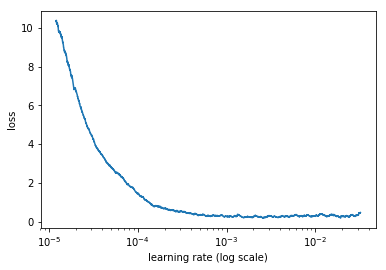

In [53]:
m.sched.plot(100)

In [ ]:
lr = 0.0001

In [ ]:
# m.fit(lr, 3, metrics=[exp_rmspe])
# m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)